In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from bboxregressiongenerator import DataGenerator
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import cv2

# Object Detection

<div class='alert alert-info'><strong>Object detection</strong> is a computer technology related to computer vision and image processing that deals with detecting instances of semantic objects of a certain class in digital images and videos. When we perform object detection we perform both classification and localization of the object of interest.</div>

- In this kernel we will be detecting single instances of a given class: **cat** or **dog**
- This approach is restricted to detecting just single instances of a class
- For detection of multiple instances of same class or a different class different regions of interest in the image need to be identified

<img src='https://user-images.githubusercontent.com/61016383/94112562-415c3200-fe63-11ea-98e8-367a4b5c1637.gif'>

In [ ]:
directory = '/kaggle/input/dog-and-cat-detection/annotations'
annotations = os.listdir(directory)

In [ ]:
 with open(os.path.join(directory,'Cats_Test0.xml'), 'r') as f:
        file = f.read()
data = BeautifulSoup(file, "xml")

objects = data.find_all('object')
length = len(objects)
filename = data.find("filename").text
img_width = int(data.find('size').width.text)
img_height = int(data.find('size').height.text)

In [ ]:
xmin = int(objects[0].bndbox.xmin.text)
ymin = int(objects[0].bndbox.ymin.text)
xmax = int(objects[0].bndbox.xmax.text)
ymax = int(objects[0].bndbox.ymax.text)

# Normalization of Bounding Box Coordinates
- Images need to be resized to a fixed size to be passed as inputs to a CNN
- Since the bounding box coordinates of an image cannot be used to localize an object of interest if we resize the image, we first normalize the bounding box coordinates using the image's orginal height and width
- These normalized coordinates can then be brought back to their integer forms by multiplying them with the resized image height and width. Now we can localize the object of interest in the resized image as well.

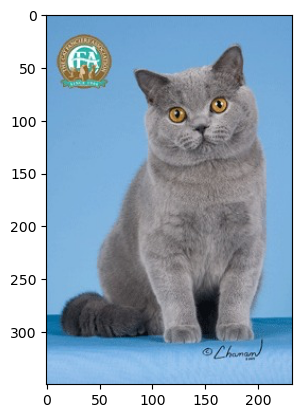

In [ ]:
img = cv2.imread("/kaggle/input/dog-and-cat-detection/images/Cats_Test0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

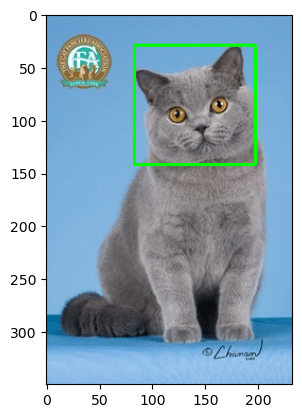

In [ ]:
img = cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (0,255,0), 2)
plt.imshow(img)

In [ ]:
img.shape

(350, 233, 3)

In [ ]:
h,w = img.shape[:2]

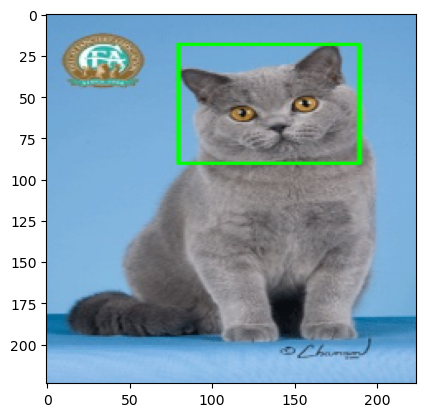

In [ ]:
xmin /= w
xmax /= w
ymin /= h
ymax /= h

img_r = cv2.resize(img, (224,224))

xmin = int(xmin*224)
xmax = int(xmax*224)
ymin = int(ymin*224)
ymax = int(ymax*224)

img_r = cv2.rectangle(img_r, (xmin,ymin), (xmax,ymax), (0,255,0), 1)
plt.imshow(img_r)

# Object Detection Meta Data
- There are going to be 2 targets
    - Class of an object
    - Bounding box to localize that object
- Hence we need to create a meta data of the image and annotations which we can pass to our custom image data generator

![image.png](attachment:761c5107-6e81-46b0-9a57-cf65a6a99920.png)

In [ ]:
records = []
for annot_file in annotations:
    
    with open(os.path.join(directory,annot_file), 'r') as f:
        file = f.read()
    data = BeautifulSoup(file, "xml")
    
    objects = data.find_all('object')
    length = len(objects)
    filename = data.find("filename").text
    img_width = int(data.find('size').width.text)
    img_height = int(data.find('size').height.text)
    
    for i in range(length):
        class_name = data.find_all('object')[i].find('name').text
        xmin = int(data.find_all('object')[i].find('bndbox').find('xmin').text)/img_width
        ymin = int(data.find_all('object')[i].find('bndbox').find('ymin').text)/img_height
        xmax = int(data.find_all('object')[i].find('bndbox').find('xmax').text)/img_width
        ymax = int(data.find_all('object')[i].find('bndbox').find('ymax').text)/img_height
        
        records.append([filename,class_name,xmin,ymin,xmax,ymax])

In [ ]:
df = pd.DataFrame(records,columns=['filename','class','xmin','ymin','xmax','ymax'])
df.drop_duplicates(subset=['filename'],inplace=True)
df['class'] = df['class'].apply(lambda x: 1.0 if x=='dog' else 0.0)
df

filename  class      xmin      ymin      xmax      ymax
0     Cats_Test2888.png    0.0  0.316294  0.109677  0.760383  0.590323
1     Cats_Test1617.png    1.0  0.366000  0.220624  0.582000  0.621103
2       Cats_Test83.png    1.0  0.310000  0.317333  0.712000  0.666667
3      Cats_Test899.png    1.0  0.386000  0.226667  0.610000  0.477333
4     Cats_Test1204.png    1.0  0.568000  0.173653  0.726000  0.383234
...                 ...    ...       ...       ...       ...       ...
3682  Cats_Test2336.png    0.0  0.005000  0.407821  0.550000  0.994413
3683  Cats_Test1987.png    0.0  0.743333  0.323529  0.950000  0.609244
3684  Cats_Test2257.png    1.0  0.374000  0.003003  0.936000  0.768769
3685  Cats_Test1057.png    0.0  0.430000  0.064067  0.786000  0.490251
3686  Cats_Test3621.png    0.0  0.352500  0.045699  0.812500  0.553763

[3686 rows x 6 columns]

In [ ]:
df['class'].value_counts()

1.0    2498
0.0    1188
Name: class, dtype: int64

In [ ]:
image_directory = '/kaggle/input/dog-and-cat-detection/images/'

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
train = df.head(3000)
test = df.tail(686).reset_index(drop=True)

In [ ]:
train_gen = DataGenerator(train,'filename',['xmin','ymin','xmax','ymax'],'class',32,256,image_directory)
test_gen = DataGenerator(test,'filename',['xmin','ymin','xmax','ymax'],'class',32,256,image_directory)

Number of records: 3000
Number of steps: 94
Number of records: 686
Number of steps: 22


# Model Definition
- We will use a pretrained network to train our model. For this kernel I have used InceptionV3
- We will freeze its layer by considering the relevance of the similarity of our dataset with the target dataset and the size of the dataset. For more details please check out this notebook: https://www.kaggle.com/code/quadeer15sh/transfer-learning-how-to-perform-finetuning

<img src='https://miro.medium.com/v2/resize:fit:960/1*gqKM5V-uo2sMFFPDS84yJw.png'>

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential

In [ ]:
img_size = 256
base_model = InceptionV3(include_top = False,
                       weights = 'imagenet',
                       input_shape = (img_size,img_size,3))

In [ ]:
for layer in base_model.layers:
    if 'mixed7' in layer.name:
        break
    layer.trainable = False

In [ ]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output1 = Dense(4, activation='sigmoid', name='bbox_reg')(x)
output2 = Dense(1, activation='sigmoid', name='classifier')(x)
model = Model(inputs=base_model.inputs, outputs=[output1,output2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss=['mse','binary_crossentropy'],
             loss_weights=[0.6,0.4],
             metrics=['accuracy'])

# Model Architecture

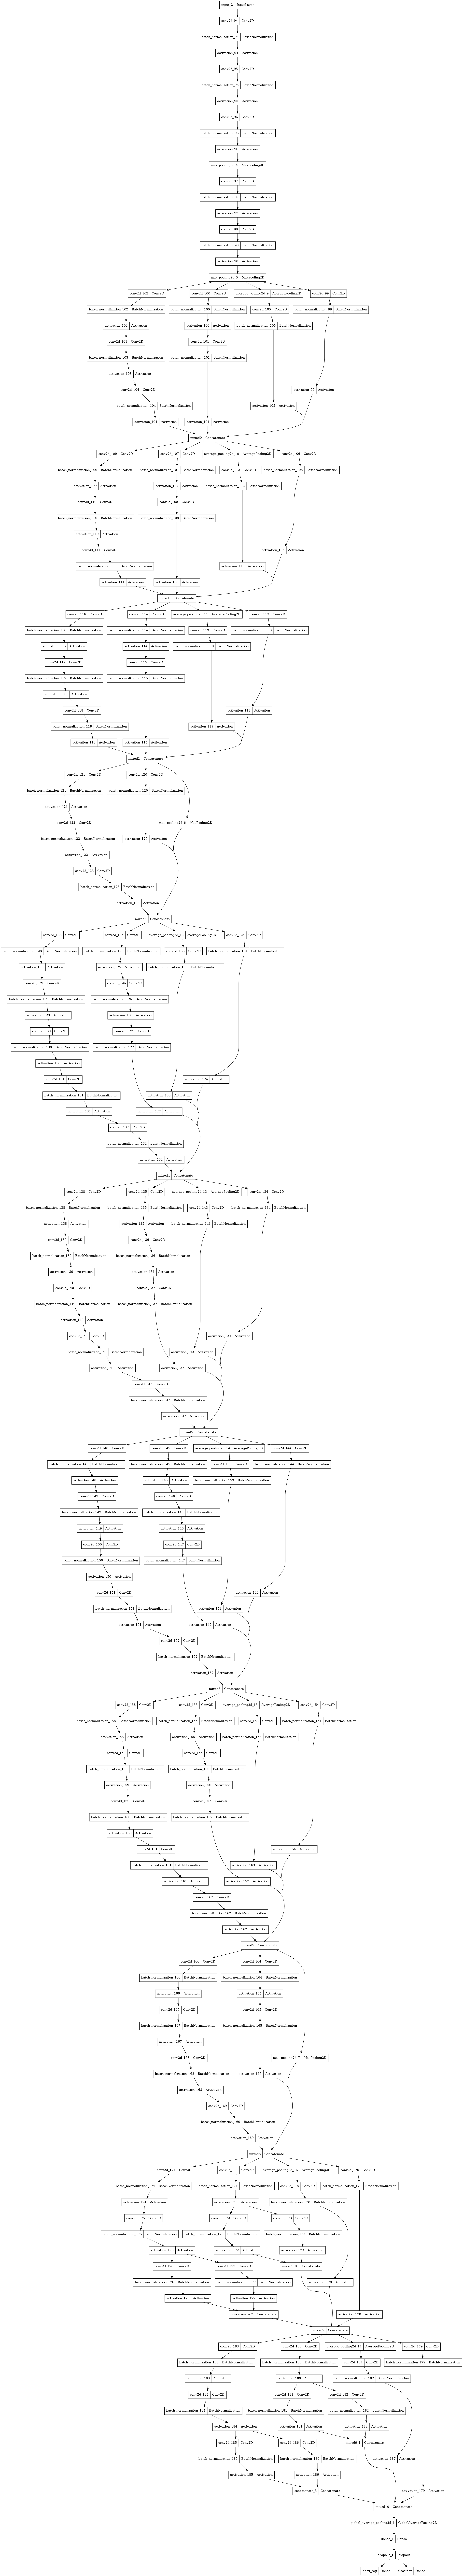

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

# Model Training

<img src='https://miro.medium.com/v2/resize:fit:1400/1*xIXqf46yYonSXkUOWcOCvg.gif'>

In [ ]:
try:
    history = model.fit(train_gen,
                        epochs=25,
                        validation_data=test_gen,
                        callbacks=[checkpoint,earlystopping])
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/25
94/94 [==============================] - ETA: 0s - loss: 0.0460 - bbox_reg_loss: 0.0356 - classifier_loss: 0.0615 - bbox_reg_accuracy: 0.6040 - classifier_accuracy: 0.9813
Epoch 1: val_loss improved from inf to 0.01326, saving model to model.h5
94/94 [==============================] - 84s 694ms/step - loss: 0.0460 - bbox_reg_loss: 0.0356 - classifier_loss: 0.0615 - bbox_reg_accuracy: 0.6040 - classifier_accuracy: 0.9813 - val_loss: 0.0133 - val_bbox_reg_loss: 0.0173 - val_classifier_loss: 0.0072 - val_bbox_reg_accuracy: 0.7303 - val_classifier_accuracy: 0.9971
Epoch 2/25
94/94 [==============================] - ETA: 0s - loss: 0.0147 - bbox_reg_loss: 0.0214 - classifier_loss: 0.0047 - bbox_reg_accuracy: 0.6740 - classifier_accuracy: 1.0000
Epoch 2: val_loss improved from 0.01326 to 0.00982, saving model to model.h5
94/94 [==============================] - 38s 403ms/step - loss: 0.0147 - bbox_reg_loss: 0.0214 - classifier_loss: 0.0047 - bbox_reg_accuracy: 0.6740 - classifier_

# Inference
- During inference we will take the outputs from the two output heads and use them for locating the object and assigning them their respective class

<img src='https://miro.medium.com/v2/resize:fit:1200/1*pyDWEf7qautBRq3lcw5xew.gif'>

In [ ]:
outputs = model.predict(test_gen)

22/22 [==============================] - 9s 333ms/step


In [ ]:
y_bbox,y_pred = outputs
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0
y_pred = y_pred.reshape(-1,)

In [ ]:
test

filename  class      xmin      ymin      xmax      ymax
0    Cats_Test2717.png    1.0  0.542000  0.165333  0.768000  0.445333
1    Cats_Test1472.png    1.0  0.097778  0.123333  0.893333  0.733333
2    Cats_Test2261.png    1.0  0.330000  0.061333  0.640000  0.448000
3    Cats_Test1662.png    0.0  0.326000  0.027027  0.626000  0.528529
4     Cats_Test256.png    1.0  0.103093  0.036667  0.958763  0.576667
..                 ...    ...       ...       ...       ...       ...
681  Cats_Test3536.png    1.0  0.436667  0.093333  0.733333  0.542222
682   Cats_Test308.png    1.0  0.182073  0.208000  0.837535  0.600000
683   Cats_Test862.png    1.0  0.092000  0.383754  0.288000  0.616246
684   Cats_Test184.png    0.0  0.461333  0.078000  0.837333  0.358000
685  Cats_Test1793.png    1.0  0.045333  0.164000  0.776000  0.750000

[686 rows x 6 columns]

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
filenames = test['filename'].sample(25).tolist()

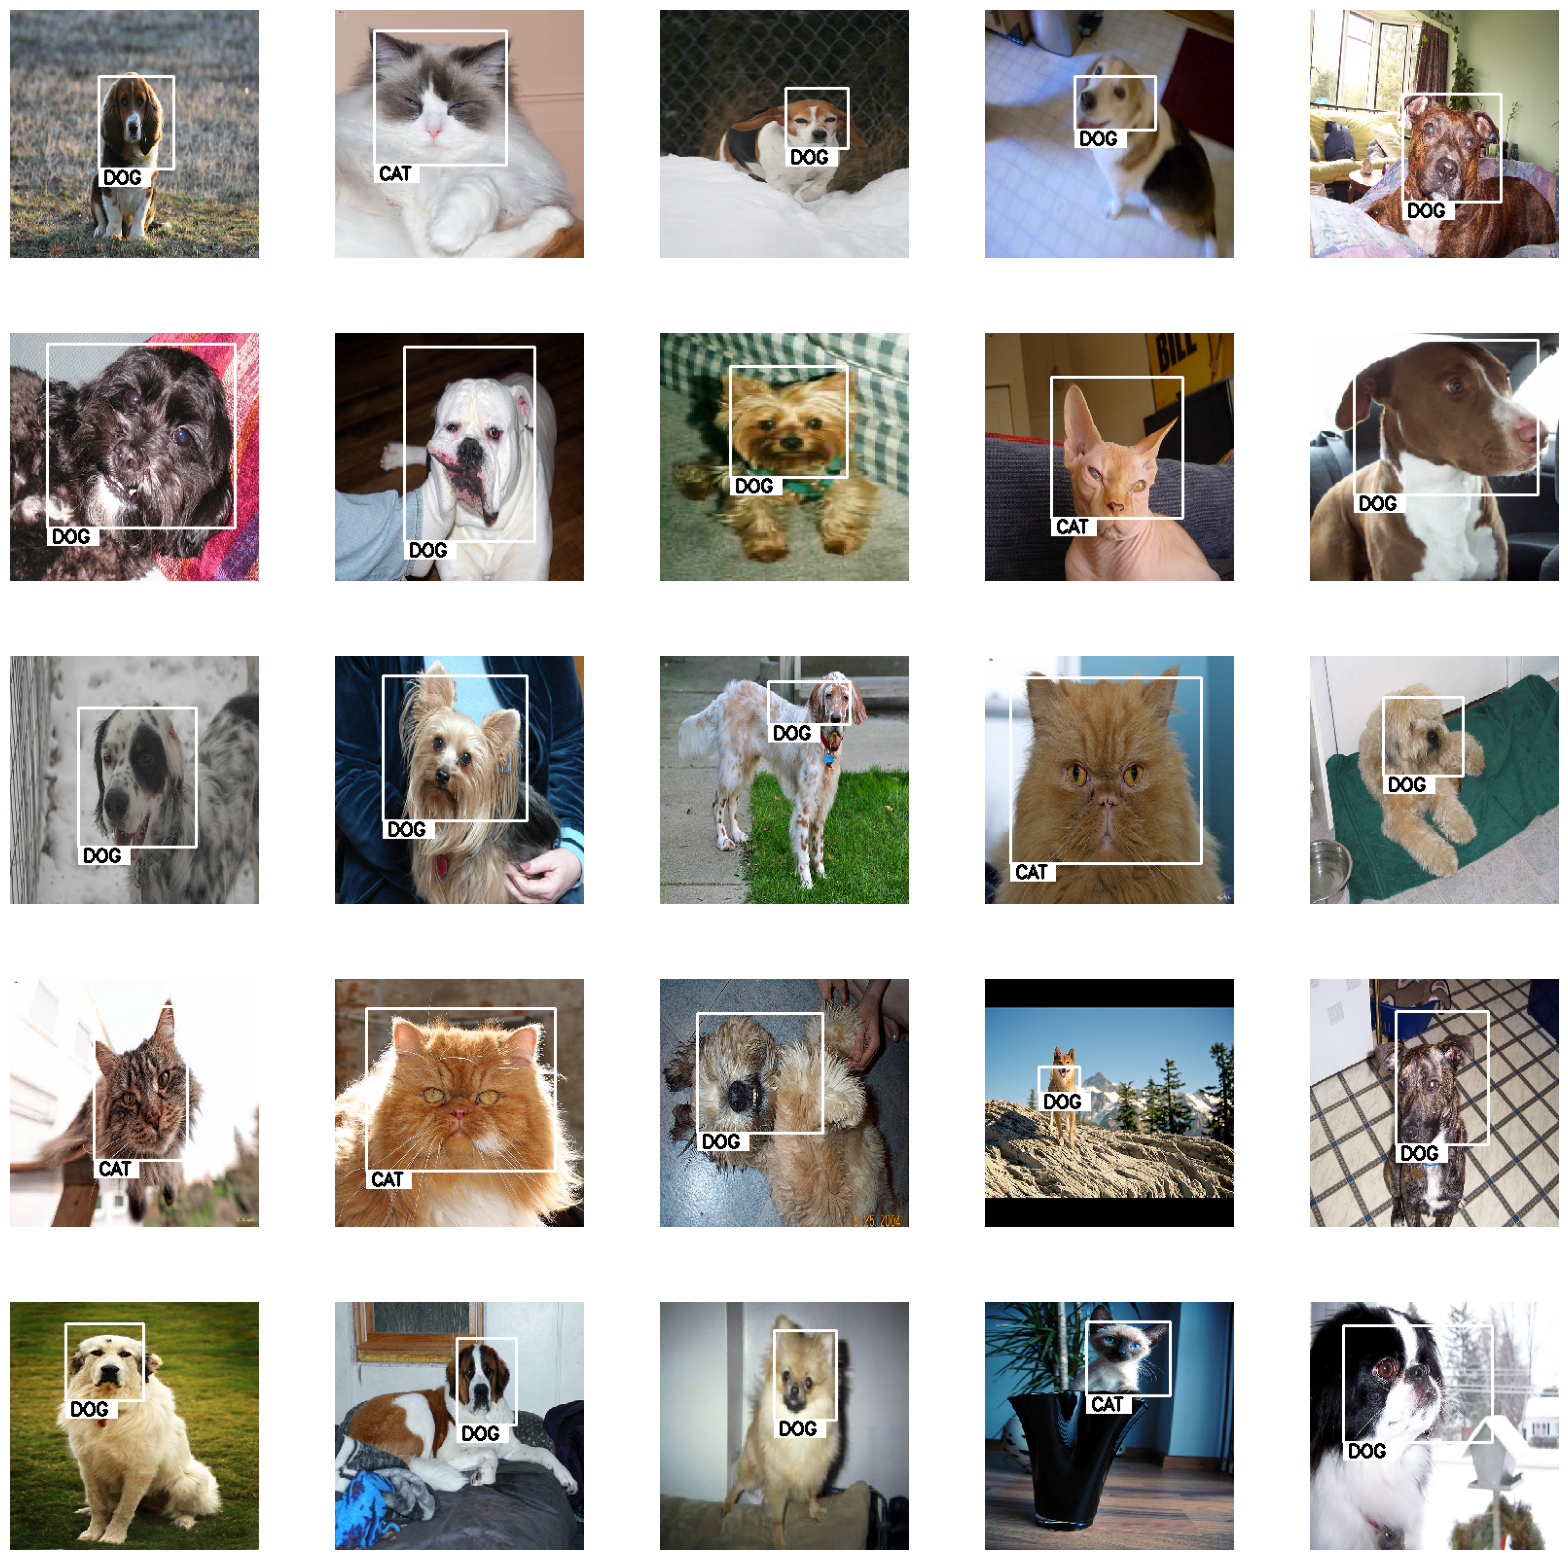

In [ ]:
labels = ['CAT','DOG']
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.8
color=(0,0,0)
thickness=2
img_size = 256

plt.figure(figsize = (20 , 20))

for ind, filename in enumerate(filenames):
    x = test[test['filename']== filename]
    label = labels[int(y_pred[x.index])]
    (width,height),b = cv2.getTextSize(label,font,fontScale,thickness)
    img = load_img(os.path.join('/kaggle/input/dog-and-cat-detection/images/',filename),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    for record in y_bbox[x.index]:
        xmin = int(record[0]*img_size)
        ymin = int(record[1]*img_size)
        xmax = int(record[2]*img_size)
        ymax = int(record[3]*img_size)
        img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,255,255),2)
        img = cv2.rectangle(img,(xmin,ymax),(xmin+width,ymax+height),(255,255,255),-1)
        img = cv2.putText(img,label,(xmin+5,ymax+15),font,fontScale-0.2,color,thickness,cv2.LINE_AA)

    plt.subplot(5 , 5, ind+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(img)
    plt.axis("off")